# Time-Series-Forecasting-Tutorial(KR)

출처 : https://www.tensorflow.org/tutorials/structured_data/time_series

In [45]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import os
import datetime
import IPython
import IPython.display

In [8]:
# M1 개발환경에서 TensorFlow를 사용하기 위한 코드입니다.
# M1 개발환경이 아닐경우 생략합니다.
from tensorflow.python.compiler.mlcompute import mlcompute
tf.compat.v1.disable_eager_execution()
mlcompute.set_mlc_device(device_name = 'any')

## 수집(Acquision)

이번 시계열 예측 튜토리얼에서 Jena Climate dataset(recorded by the [Max Planck Institute for Biogeochemistry][link])을 사용하였습니다.

이 데이터는 독일 Jena지역에서 2009년 1월 10일부터 2016년 12월 31일까지 10분 간격으로 측정된 14가지 특성으로 이루어져있습니다.


[link]: https://www.bgc-jena.mpg.de/wetter/

In [27]:
df = pd.read_csv('jena_climate_2009_2016.csv')

## 점검 및 탐색(Inspection and exploratin)

데이터 구조를 파악하기 위해, 처음 5개의 행만 출력하여 데이터를 확인합니다.

In [28]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


데이터는 시간부분을 제외하고 온도, 대기압, 습도, 풍속, 풍향 등 14개의 특성을 가지고 있습니다.<br>데이터는 10분 간격으로 나타나있으며 하루에 144개의 데이터가 기록됩니다.

`pandas_profile`을 사용하여 데이터의 분포와 통계를 살펴겠습니다.<br>그리고 몇 가지 특성에 대해서는 시각화를 하기 위해 그래프로 나타내겠습니다.

In [29]:
# pandas_profile을 사용하면 각각 특성 사이의 상관관계 분석도 가능합니다.
# 하지만 이번 튜토리얼에서 사용되는 데이터의 양이 크기 때문에 상관관계 분석은 제외하고 분석을 수행하였습니다.
profile = ProfileReport(df, minimal = True)
profile

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
# 데이터프레임 d.m.Y H:M:S 형식으로 표현되어있는 Date Time 열을 Y-m-d H:M:S 형식으로 변경하고 따로 저장합니다.
date_time = pd.to_datetime(df.pop('Date Time'), format = '%d.%m.%Y %H:%M:%S')

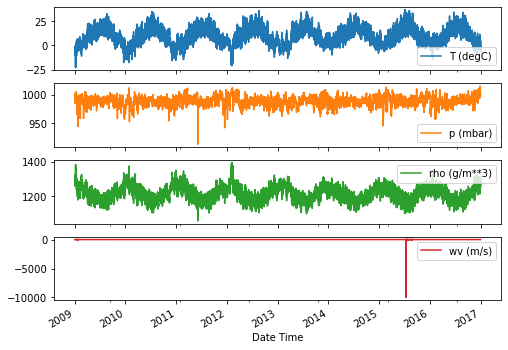

In [31]:
# matplotlib 차트의 기본 설정
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] =False

# 기온(T), 대기압(mbar), 공기밀도(rho), 풍속(wv) 네 가지 특성에 대해 그래프로 나타냅니다.
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)', 'wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

`pandas_profile`과 그래프를 통하여 데이터를 확인한 결과, 다른 특성들에서는 시간에 따른 변화가 나타나지만 풍속과 최대풍속을 나타내는 특성인 `wv` , `max. wv`에 이상이 있다고 판단됩니다.

## 전처리 및 정제(Preprocessing and Cleaning)

데이터 구조에 대한 파악 이후 학습 진행에 용이하도록 데이터 전처리를 수행합니다.<br>이전 단계에서 데이터를 살펴본 결과, `wv`, `max. wv`특성에서 최소값 `-9999`이 나타나는 것을 확인 할 수 있었습니다.

풍향에 대한 특성 `wd`가 따로 존재하기 때문에 풍속의 값은 스칼라 값으로 `>=0`의 값을 가져야합니다.<br>따라서 해당 값을 `0`으로 대체하겠습니다.

In [35]:
wv = df['wv (m/s)']
# wv에서 -9999.0 값을 가지는 열의 index를 minus_wv에 저장합니다.
minus_wv = wv == -9999.0
# wv에서 minus_wv 인덱스에 해당하는 값들을 0.0으로 변환합니다.
wv[minus_wv] = 0.0

# wv에 대해 수행했던 작업을 max. wv에도 수행합니다.
max_wv = df['max. wv (m/s)']
minus_max_wv = max_wv == -9999.0
max_wv[minus_max_wv] = 0.0

음수값 `-9999.0`이 나타나던 `wv`, `max. wv`값을 0으로 대체하였으니, 다시 그래프를 그려보겠습니다.

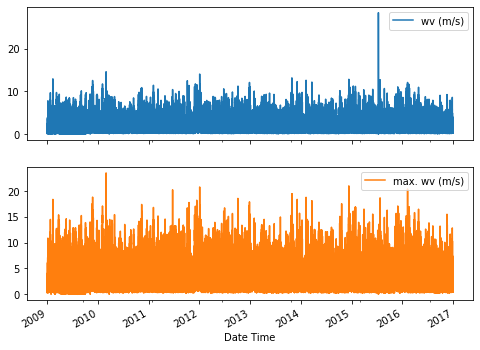

In [36]:
plot_cols = ['wv (m/s)', 'max. wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

데이터의 마지막 특성은 `wd (deg)`로 바람의 방향을 나타내고 있습니다.<br>해당 특성에 대해서 그래프로 나타내면 다음과 같습니다.

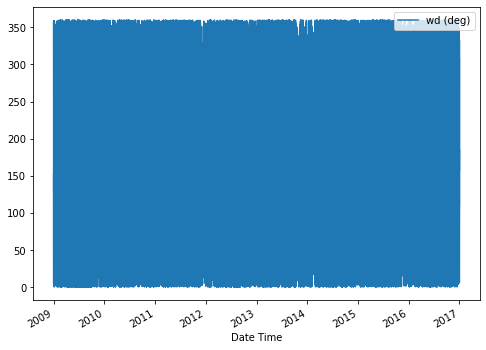

In [39]:
plot_cols = ['wd (deg)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

학습을 진행할 때 모델에 적절한 형식의 데이터를 전달해야하는데, 바람의 방향에 대한 그래프를 확인해보면 모델 입력으로 좋지 않은 모습을 나타내고 있습니다.

이는 바람의 방향을 각도로 표시하였기 때문에 나타나는 현상입니다. <br>360도와 0도는 사실상 같은 값이기 때문에 동일한 특성을 가져야 합니다.

이러한 문제를 해결하기 위해서 풍향과 풍속 데이터를 합쳐 바람에 대한 정보를 하나의 벡터로 나타내도록 하겠습니다.

In [40]:
# 풍속과 관련되어있는 데이터를 wv, max_wv로 저장합니다.
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# 풍향의 경우 각도로 표시되어있는 값을 라디안 값으로 변환하여 저장합니다.
wd_rad = df.pop('wd (deg)') * np.pi / 180

# 풍속 데이터, 라디안값으로 변환한 풍향데이터, 삼각함수를 사용하여
# 풍속과 풍향을 벡터값으로 합쳐 데이터프레임에 추가합니다.
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

df['max Wx'] = max_wv * np.cos(wd_rad)
df['max Wy'] = max_wv * np.sin(wd_rad)

벡터값으로 변환한 데이터를 그래프로 그려보면 다음과 같습니다.

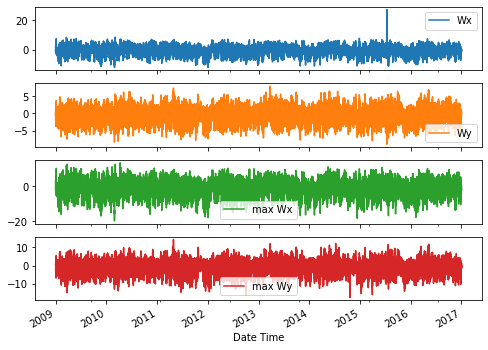

In [42]:
plot_cols = ['Wx', 'Wy', 'max Wx', 'max Wy']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

풍속에 관한 특성인 `wv`, `max. wv`에 대해서 방향을 나타내는 특성인 `wd`를 조합하여 벡터값으로 변환하여 그래프로 표현하였습니다. <br>이전 풍향을 그대로 나타냈을 때 보다는 더 의미있는 데이터로 변환되었습니다.

학습을 진행하기 전 날짜로 표기되어있는 `date_time`데이터를 학습에 용이하게 초 단위로 변환합니다.

In [43]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

다음으로 데이터를 세 부분으로 분할합니다. <br>세 부분의 역할은 각각 훈련데이터, 검증데이터, 테스트데이터 입니다.

각각의 데이터의 비율은 훈련데이터 70%, 검증데이터 20%, 테스트데이터 10%로 분할하였습니다.

In [47]:
# 훈련데이터, 검증데이터, 테스트데이터 분할
n = len(df)
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

# 특성의 수에 대해서 변수로 정의
num_features = df.shape[1]

데이터를 사용하여 훈련을 진행하기 전에 각각의 특성들은 서로다른 범위의 값을 가지기 때문에 정규화를 수행합니다.

훈련데이터의 평균, 표준편차를 사용하여 정규화를 수행하고, 검증데이터와 테스트데이터는 훈련데이터의 정보를 활용하여 정규화를 수행합니다.

In [48]:
# 훈련데이터의 평균과 표준편차
train_mean = train_df.mean()
train_std = train_df.std()

# 훈련데이터, 검증데이터, 테스트데이터 정규화
train_scaled = (train_df - train_mean) / train_std
val_scaled = (val_df - train_mean) / train_std
test_scaled = (test_df - train_mean) / train_std

## 모델링 및 훈련(Modeling and Training)